# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt




#from ydata_profiling import ProfileReport

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
df.shape

(41188, 21)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [6]:
df.isnull().sum()


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [8]:
# Get unique values for each column in the dataframe
unique_values = {col: df[col].unique() for col in df.columns}
unique_values

{'age': array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
        49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
        28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
        77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
        74, 17, 87, 91, 86, 98, 94, 84, 92, 89]),
 'job': array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
        'retired', 'management', 'unemployed', 'self-employed', 'unknown',
        'entrepreneur', 'student'], dtype=object),
 'marital': array(['married', 'single', 'divorced', 'unknown'], dtype=object),
 'education': array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
        'professional.course', 'unknown', 'university.degree',
        'illiterate'], dtype=object),
 'default': array(['no', 'unknown', 'yes'], dtype=object),
 'housing': array(['no', 'yes', 'unknown'], dtype=object),
 'loan': array(['no', 'yes', 'unknown'], dtype=object),
 'contac

In [9]:
df['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [10]:
# Rename the target column for clarity
df.rename(columns={'y': 'deposit'}, inplace=True)

In [ ]:
# Using a tool to generate a complete report over the data
profile = ProfileReport(df)
profile.to_file(output_file='data/bank_marketing_eda_report.html')

In [ ]:
# 2.1) Generate the report
profile

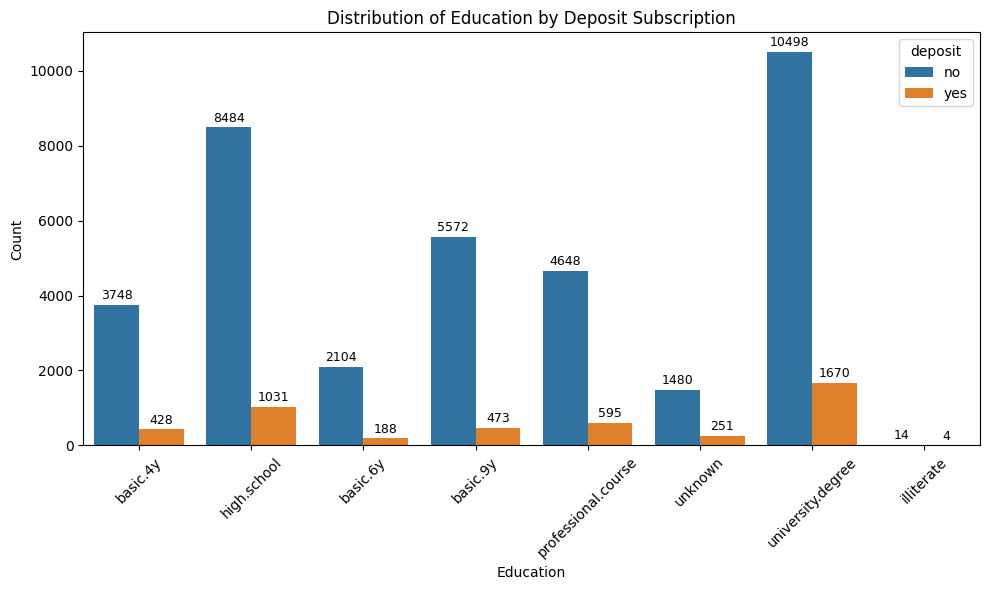

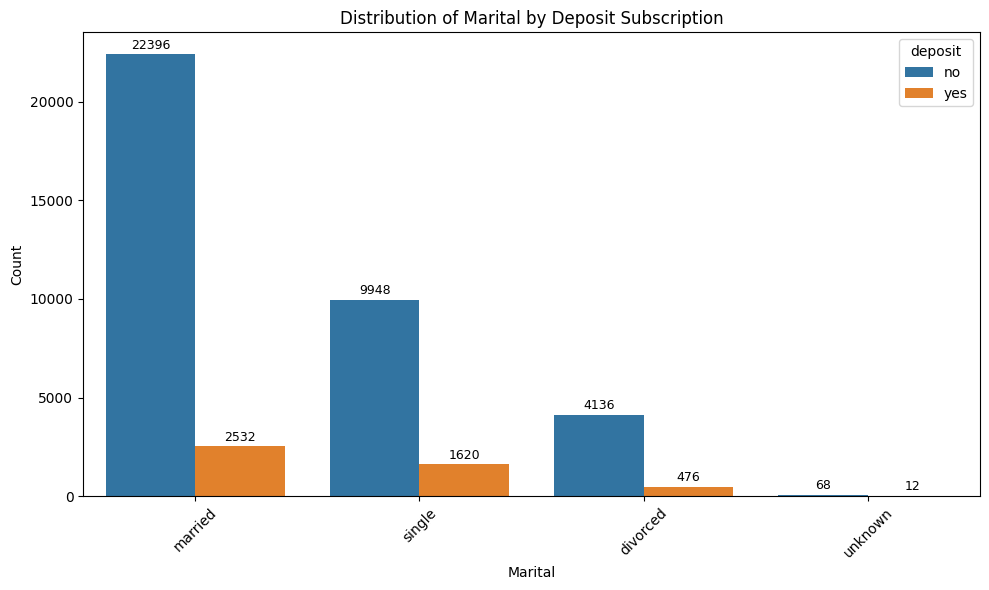

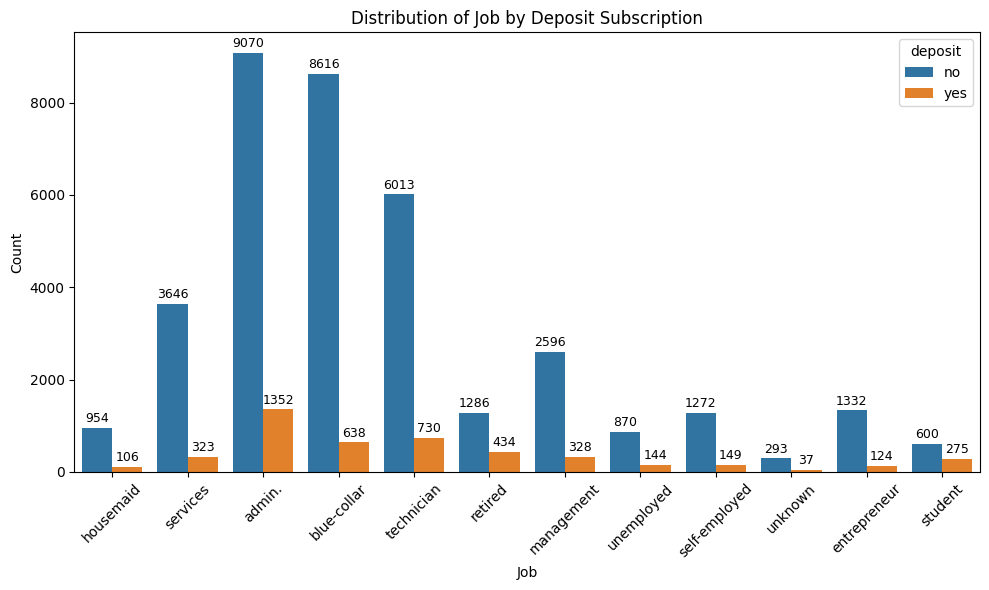

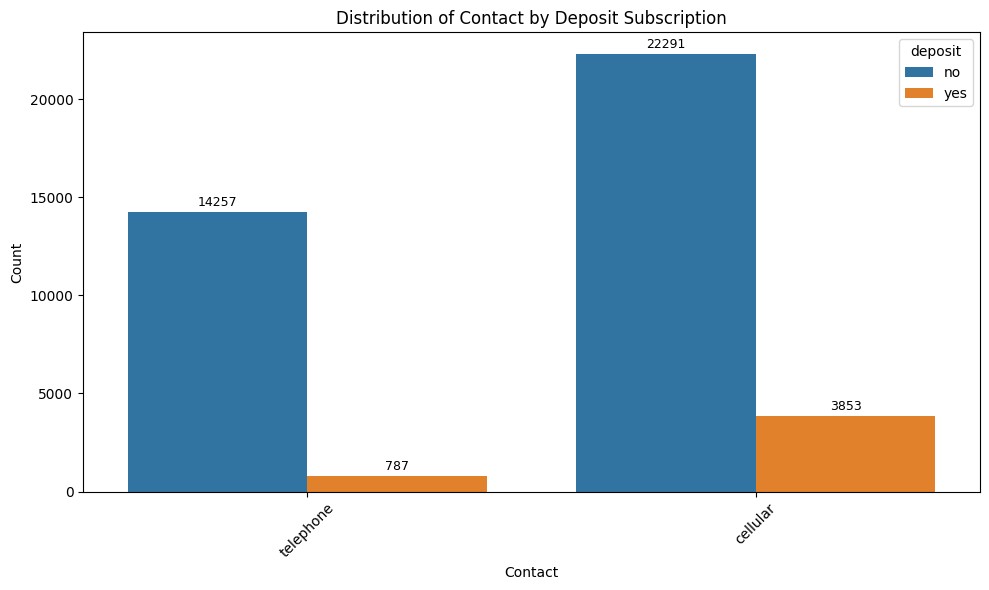

In [13]:
# 2.2) Visualize the data
# Visualize the distribution of the target variable

for feature in ['education', 'marital', 'job', 'contact']:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, x=feature, hue='deposit')
    plt.title(f'Distribution of {feature.capitalize()} by Deposit Subscription')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    # Add count labels
    for p in ax.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9, color='black', rotation=0, xytext=(0, 2), textcoords='offset points')
    plt.tight_layout()
    plt.savefig(f'images/{feature}_visualize_data_by_hist.png')
    plt.show()
    



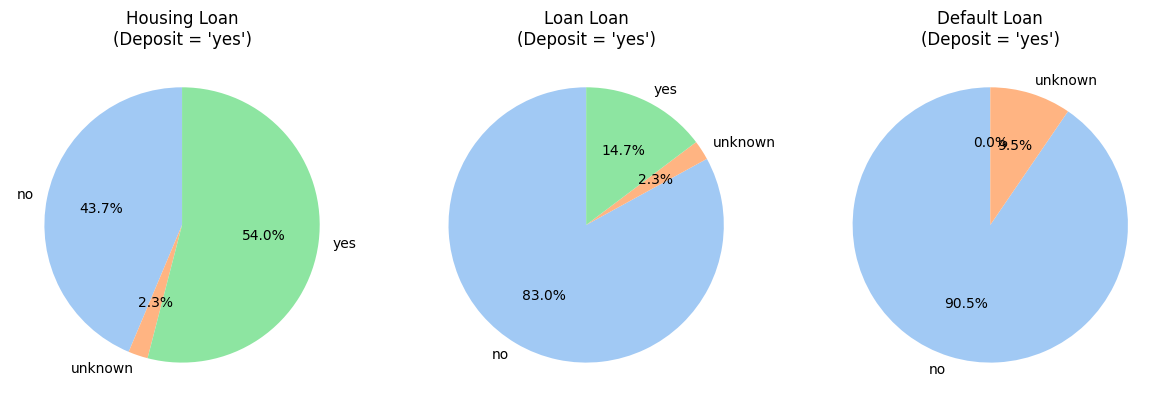

In [14]:
plt.figure(figsize=(12, 4))
for i, loan_type in enumerate(['housing', 'loan', 'default']):
    plt.subplot(1, 3, i+1)
    df_group = df.groupby([loan_type, 'deposit']).size().unstack(fill_value=0)
    df_group.plot.pie(
        y='yes',
        labels=df_group.index,
        autopct='%1.1f%%',
        legend=False,
        ax=plt.gca(),
        startangle=90,
        colors=sns.color_palette('pastel')
    )
    plt.title(f"{loan_type.capitalize()} Loan\n(Deposit = 'yes')")
    plt.ylabel('')
plt.tight_layout()
plt.savefig('images/loan_typ_visualize_pie_.png')
plt.show()


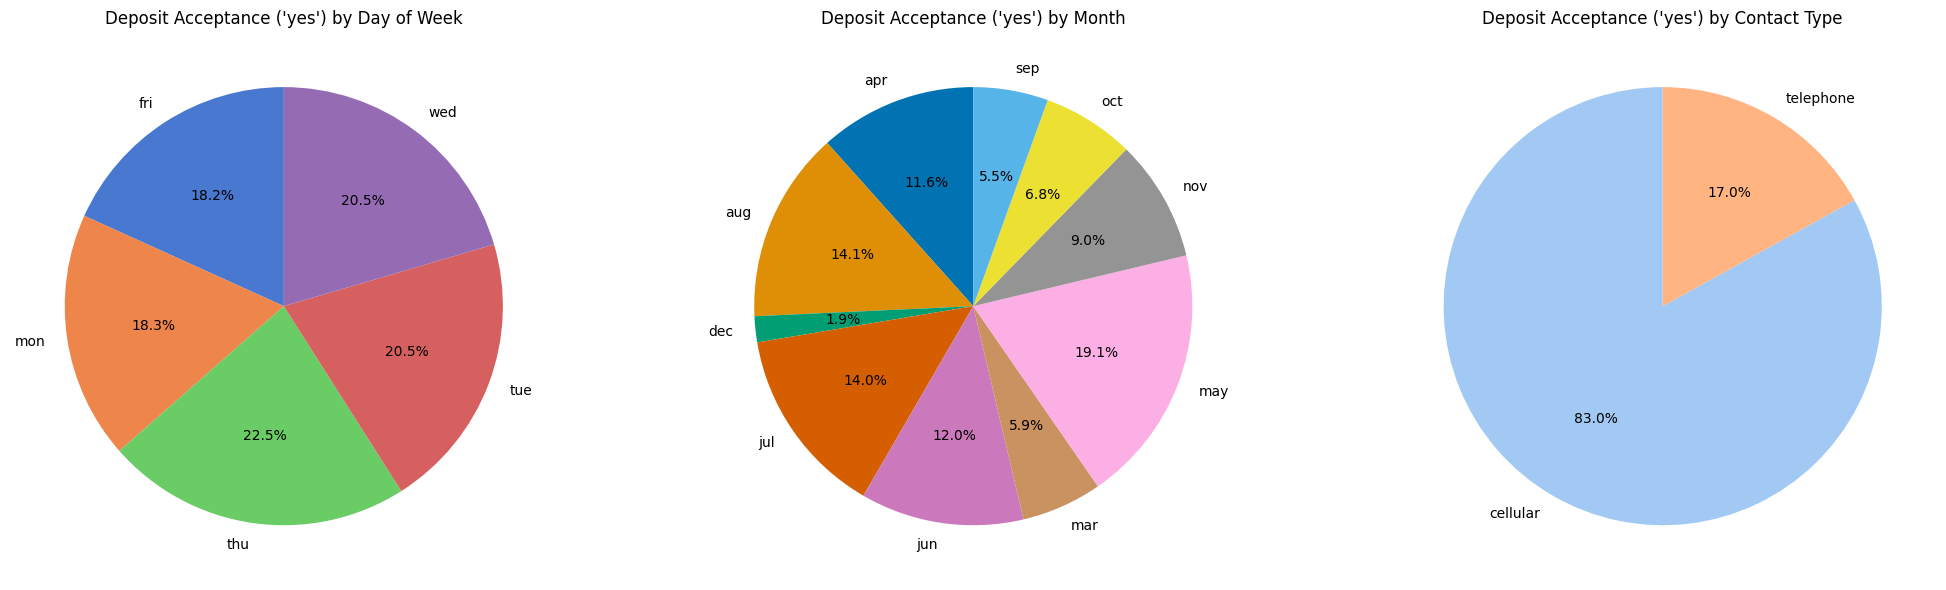

In [15]:
# Calculate deposit acceptance ('yes') by day_of_week and by month
deposit_yes = df[df['deposit'] == 'yes']['day_of_week'].value_counts().sort_index()
deposit_yes_month = df[df['deposit'] == 'yes']['month'].value_counts().sort_index()
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Pie chart for deposit acceptance by day_of_week
deposit_yes.plot.pie(
    labels=deposit_yes.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('muted'),
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Deposit Acceptance ('yes') by Day of Week")
axes[0].set_ylabel('')

# Pie chart for deposit acceptance by month
deposit_yes_month.plot.pie(
    labels=deposit_yes_month.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('colorblind'),
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Deposit Acceptance ('yes') by Month")
axes[1].set_ylabel('')

# Pie chart for deposit acceptance by contact type
deposit_counts_contact = df.groupby('contact')['deposit'].value_counts().unstack().fillna(0)
deposit_yes_contact = deposit_counts_contact['yes']
deposit_yes_contact.plot.pie(
    labels=deposit_yes_contact.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel'),
    legend=False,
    ax=axes[2]
)
axes[2].set_title("Deposit Acceptance ('yes') by Contact Type")
axes[2].set_ylabel('')

plt.tight_layout()
plt.savefig('images/day_of_week_month_contact_type.png')
plt.show()


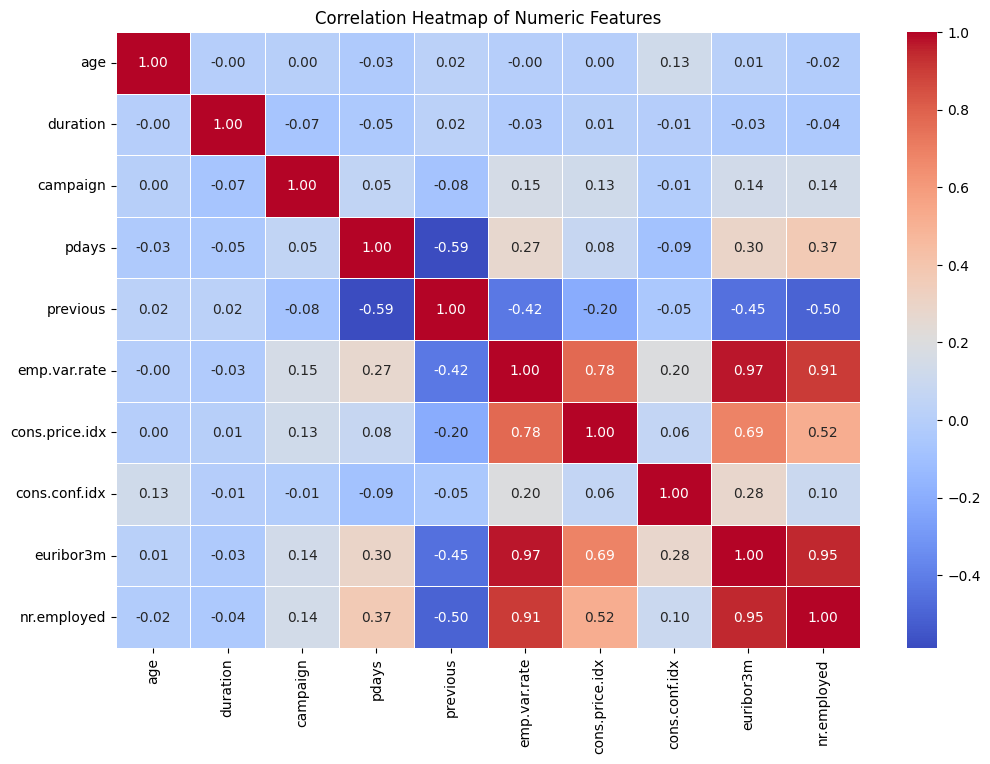

In [16]:
# Compute the correlation matrix for numeric features
corr = df.select_dtypes(include=[np.number]).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.savefig('images/heatmap_numeric.png')
plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

<b>The business objective is to develop a predictive model that accurately identifies which clients are most likely to subscribe to a term deposit Sampled on their demographic, financial, and contact information. This will enable the bank to optimize its marketing campaigns by targeting clients with the highest probability of a positive response, thereby improving campaign efficiency and increasing the rate of successful term deposit subscriptions.</b>

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [18]:
# Select only the bank client information features
bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
X = df[bank_features]
y = df['deposit'].map({'no': 0, 'yes': 1})  # Encode target as 0/1

# Identify categorical and numeric columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep any columns not explicitly transformed (e.g., if you had other types of features)
)


In [19]:
# Create a DataFrame from the transformed data using the correct feature names and index
X_processed_array = preprocessor.fit_transform(X)
feature_names_out = preprocessor.get_feature_names_out()
X_encoded_df = pd.DataFrame(X_processed_array.toarray(), columns=feature_names_out)
X_encoded_df.head()


,num__age,cat__job_blue-collar,cat__job_entrepreneur,cat__job_housemaid,cat__job_management,cat__job_retired,cat__job_self-employed,cat__job_services,cat__job_student,cat__job_technician,...,cat__education_illiterate,cat__education_professional.course,cat__education_university.degree,cat__education_unknown,cat__default_unknown,cat__default_yes,cat__housing_unknown,cat__housing_yes,cat__loan_unknown,cat__loan_yes
0,1.533034,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.628993,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.290186,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.002309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.533034,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
X = X_encoded_df
X.head()

,num__age,cat__job_blue-collar,cat__job_entrepreneur,cat__job_housemaid,cat__job_management,cat__job_retired,cat__job_self-employed,cat__job_services,cat__job_student,cat__job_technician,...,cat__education_illiterate,cat__education_professional.course,cat__education_university.degree,cat__education_unknown,cat__default_unknown,cat__default_yes,cat__housing_unknown,cat__housing_yes,cat__loan_unknown,cat__loan_yes
0,1.533034,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.628993,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.290186,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.002309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.533034,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
X_train.shape, X_test.shape

((32950, 28), (8238, 28))

In [23]:
y_test.value_counts()

deposit
0    7310
1     928
Name: count, dtype: int64

In [24]:
y_train.value_counts()

deposit
0    29238
1     3712
Name: count, dtype: int64

In [25]:
X_test.head()

,num__age,cat__job_blue-collar,cat__job_entrepreneur,cat__job_housemaid,cat__job_management,cat__job_retired,cat__job_self-employed,cat__job_services,cat__job_student,cat__job_technician,...,cat__education_illiterate,cat__education_professional.course,cat__education_university.degree,cat__education_unknown,cat__default_unknown,cat__default_yes,cat__housing_unknown,cat__housing_yes,cat__loan_unknown,cat__loan_yes
14455,-0.769980,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36380,-0.290186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40076,3.164336,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10778,0.381527,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
27939,-1.153816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Problem 7: A Sampleline Model

Before we build our first model, we want to establish a baseline.  What is the Sampleline performance that our classifier should aim to beat?

In [26]:
#Defining and initilizing Arrays for the for the metrics record
Models = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'Dummy Classifier']
accuracy_scores = []
classification_reports = []
confusion_matrices = []
roc_auc_scores = []
fit_durations = []
recall_scores = []
f1_scores = []
best_params = []
auc_scores = []
best_estimators = []
train_accuracy = []
test_accuracy = []


# Define a function to evaluate the model

In [27]:



# Fix the assignment to the train_accuracy and test_accuracy lists

def record_metrics(model_name,model,X_train, y_true, y_pred, y_proba, fit_duration):
    Models.append(model_name)
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    classification_reports.append(classification_report(y_true, y_pred, output_dict=True))
    confusion_matrices.append(confusion_matrix(y_true, y_pred))
    roc_auc_scores.append(roc_auc_score(y_true, y_proba))
    fit_durations.append(fit_duration)
    recall_scores.append(recall_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred))
    best_params.append(model.get_params())
    auc_scores.append(roc_auc_score(y_true, y_proba))
    best_estimators.append(model)
    train_accuracy.append(accuracy_score(y_train, model.predict(X_train)))
    test_accuracy.append(accuracy_score(y_true, y_pred))

def print_metrics(model_name,model,X_train, y_true, y_pred, y_proba, fit_duration):
    print(f"{model_name} Metrics:")
    print(f"Fit Duration: {fit_duration:.4f} seconds")
    print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
   # train_accuracy = accuracy_score(y_train, model_name.predict(X_train))
    #print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Accuracy: {accuracy_score(y_train, model.predict(X_train)):.4f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    
def show_metric_plots(model_name, y_true, y_pred, y_proba):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='YlGnBu', ax=axes[0])
    axes[0].set_title(f"{model_name} - Confusion Matrix")

    # ROC Curve
    RocCurveDisplay.from_predictions(y_true, y_proba, ax=axes[1])
    axes[1].set_title(f"{model_name} - ROC Curve")  

    # Precision-Recall Curve
    PrecisionRecallDisplay.from_predictions(y_true, y_proba, ax=axes[2])
    axes[2].set_title(f"{model_name} - Precision-Recall Curve")

    plt.tight_layout()
    plt.savefig(f'images/{model_name}_show_metric_plots.png')
    plt.show()

    # get feature importance for tree-based models or coefficients for linear models
def plot_feature_importance(pipe):
    model = pipe.named_steps['model']
    if hasattr(model, 'feature_importances_'):
        get_feature_importance(pipe)
        plt.title('Feature Importance')
        plt.show()
    elif hasattr(model, 'coef_'):
        get_feature_importance_by_coef(pipe)
        plt.title('Feature Coefficients')
        plt.show()
    else:
        print("This model does not provide feature importances or coefficients.")

def get_feature_importance(pipe):
    features_df = pd.DataFrame(index=X_train.columns, data=pipe.named_steps['model'].feature_importances_, columns=['Feature Importance']).sort_values(by='Feature Importance')
    features_df = features_df.reset_index()
    features_df.columns = ['Features', 'Feature Importance']
    plt.figure(figsize=(12, 6))
    sns.barplot(data=features_df, x='Features', y='Feature Importance', hue='Features')
    plt.xticks(rotation=90);
def get_feature_importance_by_coef(pipe):
    feature_coef = pd.DataFrame({
        'coef': pipe.named_steps['model'].coef_[0]
    }, index=X_train.columns).sort_values(by='coef')
    
    feature_coef = feature_coef.reset_index()
    feature_coef.columns = ['Features', 'Coef']
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_coef, x='Features', y='Coef', hue='Features')
    plt.xticks(rotation=90);
    # def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    #     plt.figure(figsize=(6, 5))
    #     disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues')
    #     plt.title(f"{model_name} - Confusion Matrix")
    #     plt.show()

    # def plot_roc_curve(y_true, y_proba, model_name="Model"):
    #     plt.figure(figsize=(6, 5))
    #     RocCurveDisplay.from_predictions(y_true, y_proba)
    #     plt.title(f"{model_name} - ROC Curve")
    #     plt.show()

    # def plot_precision_recall_curve(y_true, y_proba, model_name="Model"):
    #     plt.figure(figsize=(6, 5))
    #     PrecisionRecallDisplay.from_predictions(y_true, y_proba)
    #     plt.title(f"{model_name} - Precision-Recall Curve")
    #     plt.show()

Base Model- DummyClassifier Metrics:
Fit Duration: 0.0056 seconds
Test Accuracy: 0.8037
Train Accuracy: 0.8002
Accuracy: 0.8037
Recall: 0.1196
F1 Score: 0.1207
ROC AUC: 0.5051
Confusion Matrix:
[[6510  800]
 [ 817  111]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      7310
           1       0.12      0.12      0.12       928

    accuracy                           0.80      8238
   macro avg       0.51      0.51      0.51      8238
weighted avg       0.80      0.80      0.80      8238



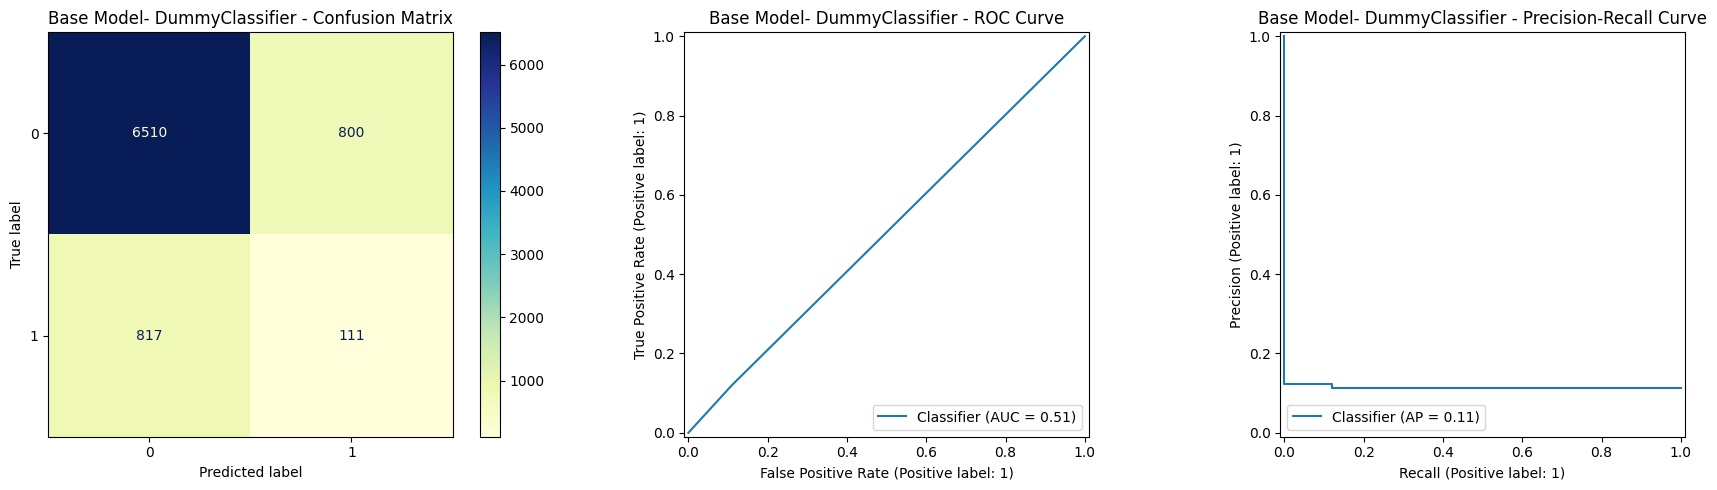

This model does not provide feature importances or coefficients.


In [28]:

import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress UndefinedMetricWarning from sklearn
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Initialize the metrics lists (overwrite if already defined)
Models =[]
accuracy_scores = []
classification_reports = []
confusion_matrices = []
roc_auc_scores = []
fit_durations = []
recall_scores = []
f1_scores = []
best_params = []
auc_scores = []
best_estimators = []
train_accuracy = []
test_accuracy = []

Sample_model = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=False)),  # Set with_mean=False to avoid issues with sparse matrices
    ('model', DummyClassifier(strategy='stratified',random_state=42, ))  # Dummy classifier for Sampleline
    ])

# Build and fit a Sample Logistic Regression model
start_time = time.time()
# Sample_model = LogisticRegression(max_iter=1000, random_state=42)
Sample_model.fit(X_train, y_train)
fit_duration = time.time() - start_time

# Predict and calculate metrics
y_pred = Sample_model.predict(X_test)
y_proba = Sample_model.predict_proba(X_test)[:, 1]

#print(f"Train Accuracy: {accuracy_score(y_train, Sample_model.predict(X_train)):.4f}")
record_metrics("Base Model- DummyClassifier",Sample_model,X_train, y_test, y_pred, y_proba, fit_duration)
print_metrics("Base Model- DummyClassifier",Sample_model,X_train, y_test, y_pred, y_proba,fit_duration)
show_metric_plots("Base Model- DummyClassifier",y_test, y_pred, y_proba)
# Plot feature importance or coefficients
plot_feature_importance(Sample_model)



### Key Performance Metrics:

- **Accuracy:** The model has an accuracy of 0.8037 (80.37%). This indicates that approximately 80.37% of all predictions were correct.
- **Recall:** For the positive class (class 1), the recall is 0.1196 (approximately 12%). This means the model only correctly identified about 12% of all actual positive cases.
- **F1 Score:** The F1 Score for the positive class is 0.1207, which is quite low, reflecting the poor balance between precision and recall for that class.
- **ROC AUC:** The ROC AUC is 0.5051. An AUC of 0.5 suggests the model performs no better than random guessing.

### Overall Summary

The base model logistic regression, despite a seemingly reasonable overall accuracy of 80.37%, performs very poorly in identifying the positive class (class 1). This is evident from the extremely low recall (0.12) and F1-score (0.12) for class 1, as well as the ROC AUC of 0.5051 which suggests almost random classification. The model tends to predict the majority class (class 0) much more often, leading to a high number of false negatives for the minority class. This model would be unsuitable for scenarios where identifying the positive class is crucial. Further model improvements, potentially involving techniques to handle class imbalance (e.g., oversampling, undersampling, using different algorithms, or adjusting class weights), are critically needed.#Key Performance Metrics:


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

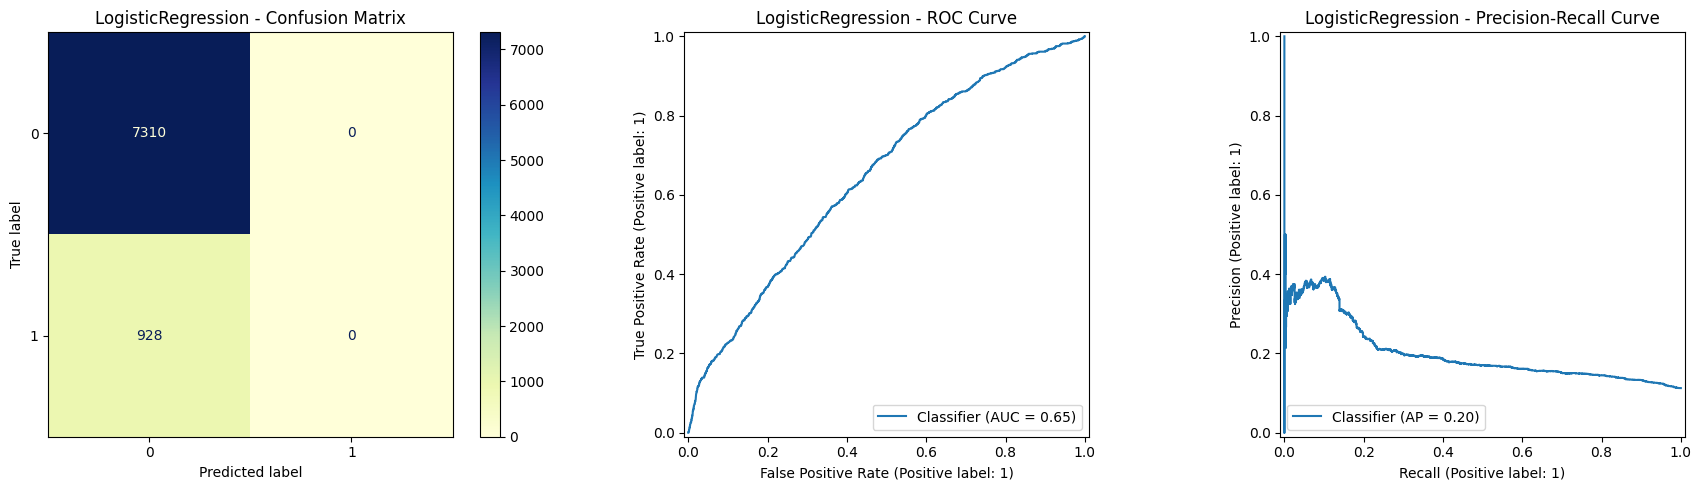

In [29]:
#Pipeline for LogisticRegression model
lr_pipe = Pipeline ([
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(random_state=42, max_iter=10000))
])

lr_start_time = time.time()
lr_pipe.fit(X_train, y_train)
lr_end_time = time.time()
fit_duration = lr_end_time - lr_start_time

# Predict and calculate metrics
y_pred = lr_pipe.predict(X_test)
y_proba = lr_pipe.predict_proba(X_test)[:, 1]
record_metrics('LogisticRegression',lr_pipe,X_train, y_test, y_pred, y_proba, fit_duration)
#print_metrics("Logistic Regression Pipeline",lr_pipe,X_train, y_test, y_pred, y_proba,fit_duration)
show_metric_plots("LogisticRegression", y_test, y_pred, y_proba)

### Problem 9: Score the Model

What is the accuracy of your model?

Logistic Regression Pipeline Metrics:
Fit Duration: 0.0266 seconds
Test Accuracy: 0.8874
Train Accuracy: 0.8873
Accuracy: 0.8874
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.6490
Confusion Matrix:
[[7310    0]
 [ 928    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7310
           1       0.00      0.00      0.00       928

    accuracy                           0.89      8238
   macro avg       0.44      0.50      0.47      8238
weighted avg       0.79      0.89      0.83      8238



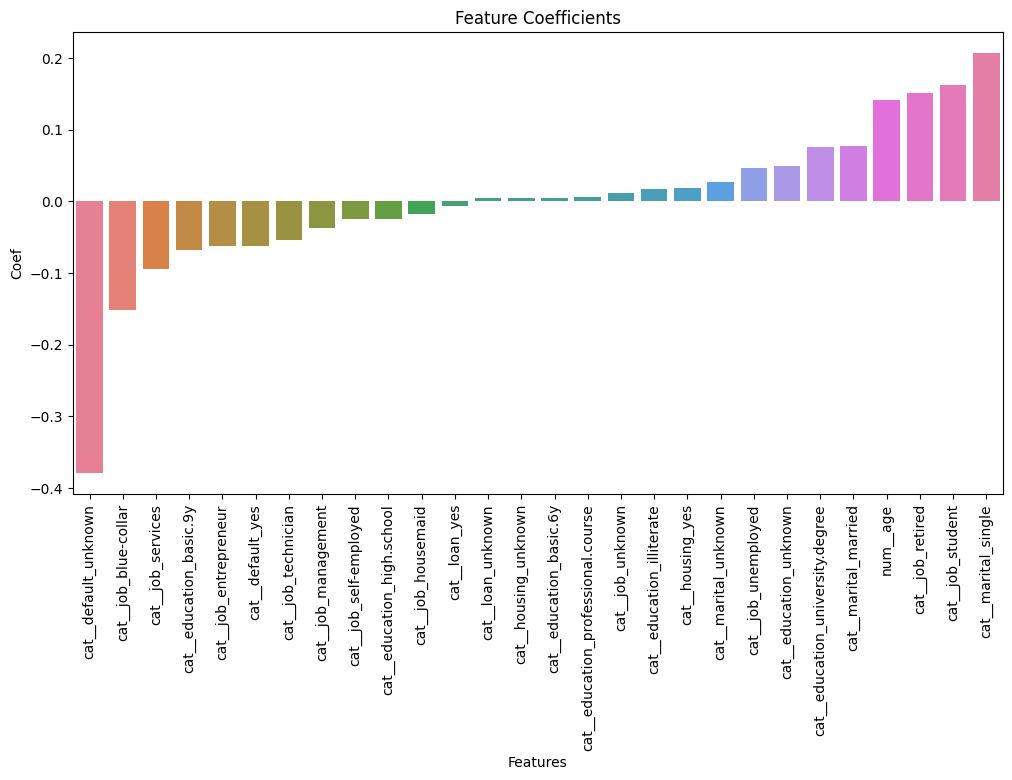

In [30]:
print_metrics("Logistic Regression Pipeline",lr_pipe,X_train, y_test, y_pred, y_proba,fit_duration)
plot_feature_importance(lr_pipe)

#### **Logistic Regression Model Performance**

- **Accuracy:** 0.8874 (88.74%) — This high accuracy is misleading due to the strong class imbalance.
- **Recall (Class 1):** 0.00 — The model fails to identify any positive (minority) cases.
- **F1 Score (Class 1):** 0.00 — Indicates no balance between precision and recall for the minority class.
- **ROC AUC:** 0.6492 — Shows some ability to separate classes, but not enough to be useful for the minority class.
- **Prediction Pattern:** The model predicts only the majority class, making it ineffective for identifying likely term deposit subscribers.
- **Next Steps:** Addressing class imbalance (e.g., resampling, class weights) is critical for improving model utility.


#### **Overall  Summary:**

The Sample model logistic regression is severely imbalanced in its predictions, effectively classifying all instances as the majority class (class 0). While it achieves high accuracy due to the large number of true negatives, its inability to identify any instances of the minority class (recall of 0.00 for class 1) makes it an ineffective model for tasks where identifying the minority class is important. Further work is needed to address this class imbalance and improve the model's performance on the minority class.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

Decision Tree Pipeline Metrics:
Fit Duration: 0.0541 seconds
Test Accuracy: 0.8638
Train Accuracy: 0.9171
Accuracy: 0.8638
Recall: 0.0862
F1 Score: 0.1248
ROC AUC: 0.5748
Confusion Matrix:
[[7036  274]
 [ 848   80]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      7310
           1       0.23      0.09      0.12       928

    accuracy                           0.86      8238
   macro avg       0.56      0.52      0.53      8238
weighted avg       0.82      0.86      0.84      8238



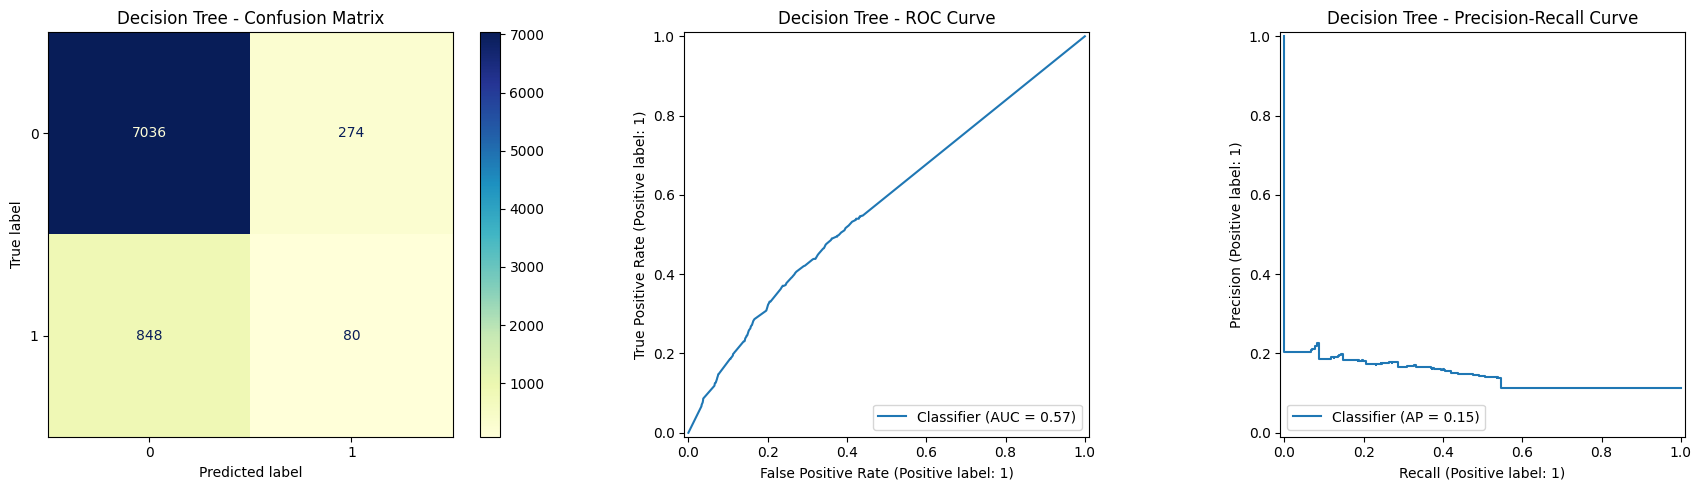

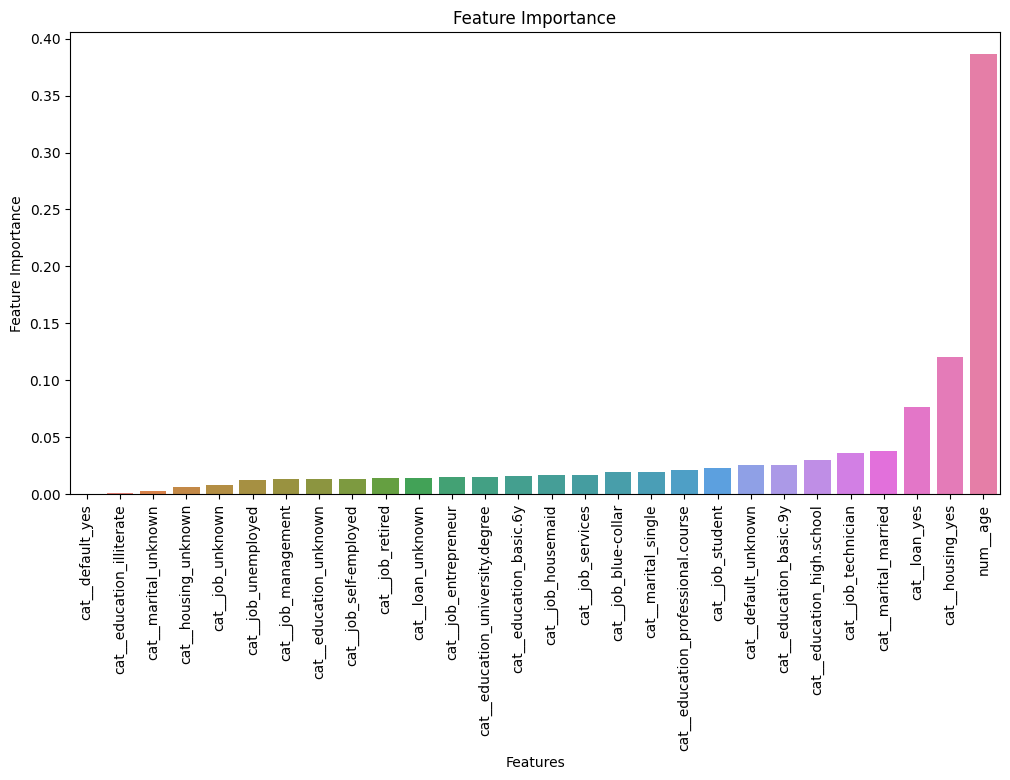

In [31]:
# Pipeline for Decision Tree Classifier
dt_pipe = Pipeline([
    ('scale', StandardScaler(with_mean=False)),
    ('model', DecisionTreeClassifier(random_state=42))
])

dt_start_time = time.time()
dt_pipe.fit(X_train, y_train)
dt_end_time = time.time()
dt_fit_duration = dt_end_time - dt_start_time
# Predict and calculate metrics
y_pred = dt_pipe.predict(X_test)
y_proba = dt_pipe.predict_proba(X_test)[:, 1]
record_metrics("Decision Tree",dt_pipe,X_train, y_test, y_pred, y_proba, dt_fit_duration)
print_metrics("Decision Tree Pipeline",dt_pipe,X_train, y_test, y_pred, y_proba,dt_fit_duration)
show_metric_plots("Decision Tree", y_test, y_pred, y_proba)
plot_feature_importance(dt_pipe)

KNN Pipeline Metrics:
Fit Duration: 0.0062 seconds
Test Accuracy: 0.8797
Train Accuracy: 0.8917
Accuracy: 0.8797
Recall: 0.0765
F1 Score: 0.1253
ROC AUC: 0.5968
Confusion Matrix:
[[7176  134]
 [ 857   71]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94      7310
           1       0.35      0.08      0.13       928

    accuracy                           0.88      8238
   macro avg       0.62      0.53      0.53      8238
weighted avg       0.83      0.88      0.84      8238



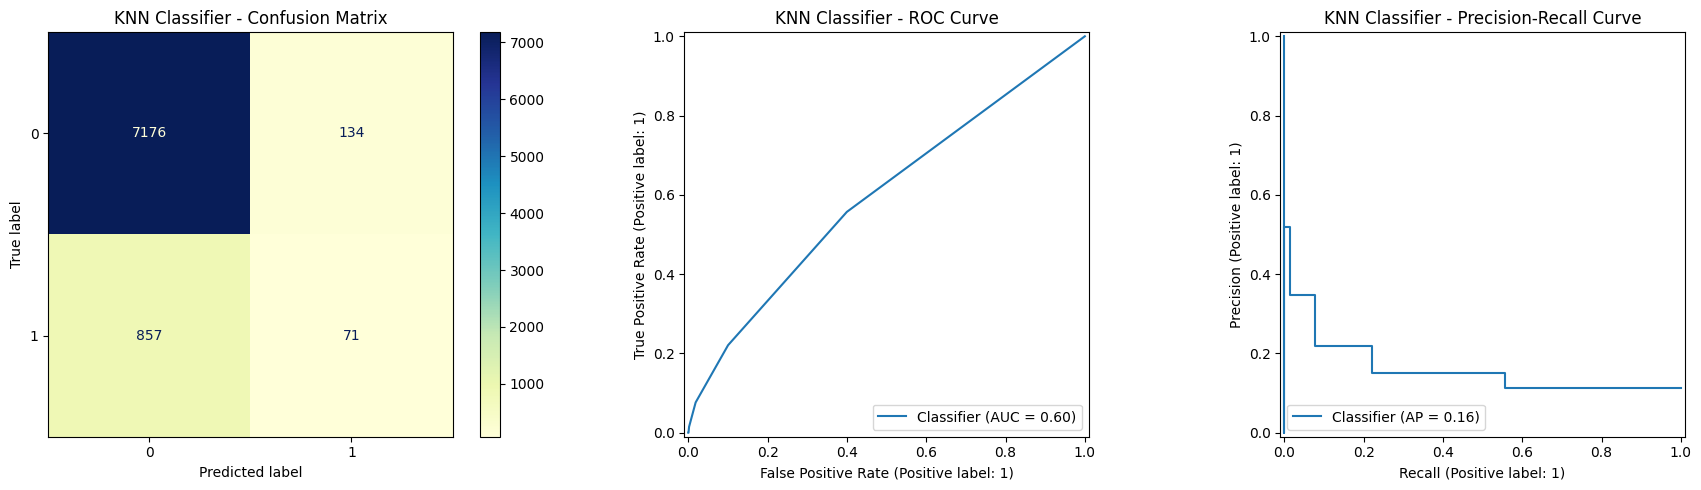

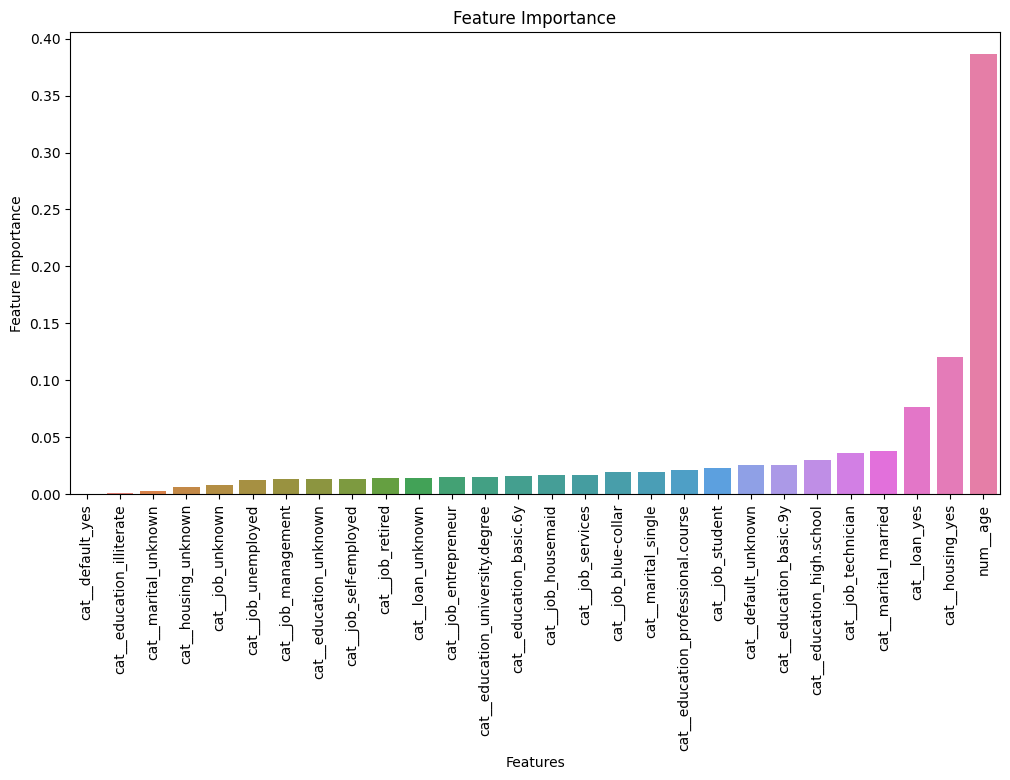

In [32]:
# Pipeline for KNN Classifier
knn_pipe = Pipeline([
    ('scale', StandardScaler(with_mean=False)),
    ('model', KNeighborsClassifier())
])

knn_start_time = time.time()
knn_pipe.fit(X_train, y_train)
knn_end_time = time.time()
knn_fit_duration = knn_end_time - knn_start_time

# Predict and calculate metrics
y_pred = knn_pipe.predict(X_test)
y_proba = knn_pipe.predict_proba(X_test)[:, 1]
record_metrics("KNN Classifier",knn_pipe, X_train, y_test, y_pred, y_proba, knn_fit_duration)
print_metrics("KNN Pipeline", knn_pipe, X_train, y_test, y_pred, y_proba, knn_fit_duration)
show_metric_plots("KNN Classifier", y_test, y_pred, y_proba)
plot_feature_importance(dt_pipe)

SVM Pipeline Metrics:
Fit Duration: 60.0625 seconds
Test Accuracy: 0.8875
Train Accuracy: 0.8876
Accuracy: 0.8875
Recall: 0.0022
F1 Score: 0.0043
ROC AUC: 0.5445
Confusion Matrix:
[[7309    1]
 [ 926    2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7310
           1       0.67      0.00      0.00       928

    accuracy                           0.89      8238
   macro avg       0.78      0.50      0.47      8238
weighted avg       0.86      0.89      0.83      8238



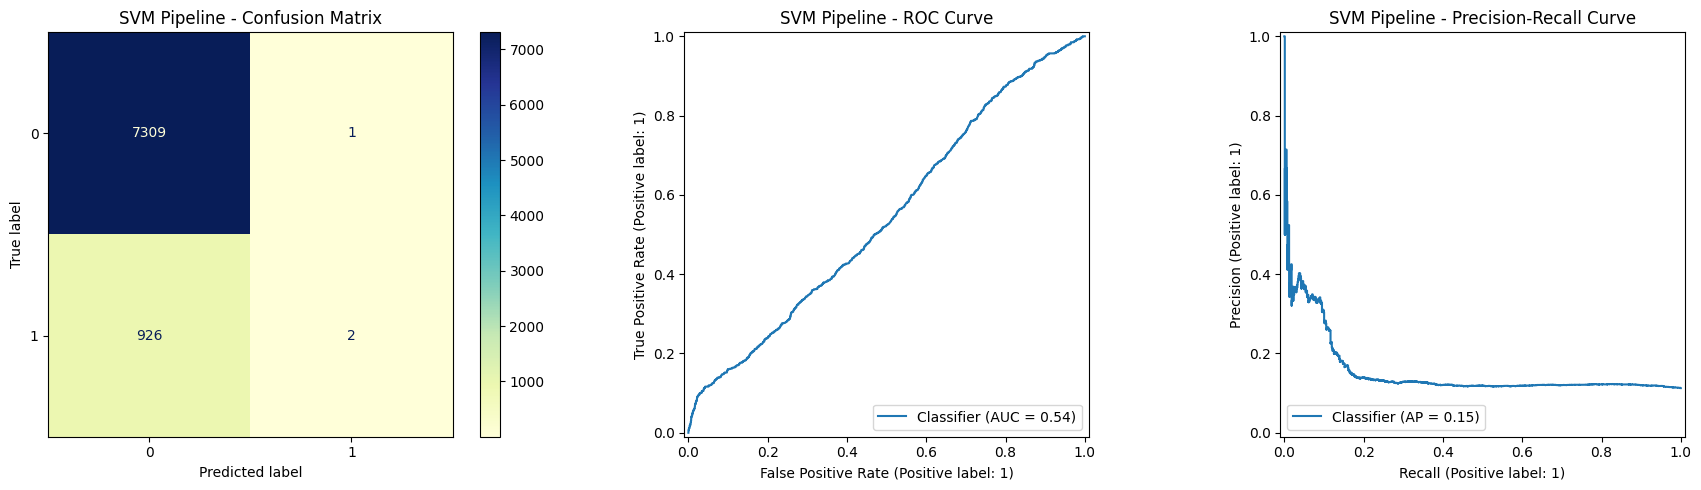

This model does not provide feature importances or coefficients.


In [33]:
# Pipeline for SVM Classifier
svm_pipe = Pipeline([
    ('scale', StandardScaler(with_mean=False)),
    ('model', SVC(probability=True, random_state=42))
])

svm_start_time = time.time()
svm_pipe.fit(X_train, y_train)
svm_end_time = time.time()
svm_fit_duration = svm_end_time - svm_start_time

# Predict and calculate metrics
y_pred = svm_pipe.predict(X_test)
y_proba = svm_pipe.predict_proba(X_test)[:, 1]
record_metrics("SVM",svm_pipe, X_train, y_test, y_pred, y_proba, svm_fit_duration)
print_metrics("SVM Pipeline", svm_pipe, X_train, y_test, y_pred, y_proba, svm_fit_duration)
show_metric_plots("SVM Pipeline", y_test, y_pred, y_proba)
plot_feature_importance(svm_pipe)

In [34]:
# print(f"Length of Models: {len(Models)}")
# print(f"Length of accuracy_scores: {len(accuracy_scores)}")
# print(f"Length of recall_scores: {len(recall_scores)}")
# print(f"Length of f1_scores: {len(f1_scores)}")
# print(f"Length of roc_auc_scores: {len(roc_auc_scores)}")
# print(f"Length of fit_durations: {len(fit_durations)}")
# print(f"Length of train_accuracy: {len(train_accuracy)}")
# print(f"Length of test_accuracy: {len(test_accuracy)}")
metric_df = pd.DataFrame({
    'Model': Models,
    'Accuracy': accuracy_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'ROC AUC': roc_auc_scores,
    'Fit Duration (s)': fit_durations,
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
})
metric_df = metric_df.sort_values(by='F1 Score', ascending=False)
pd.set_option('display.max_colwidth', None)
metric_df
# Save the metrics DataFrame to a CSV file
#metric_df.to_csv('data/model_metrics.csv', index=False)


# # Save the classification reports to a JSON file
# import json
# classification_reports_dict = {model: report for model, report in zip(Models, classification_reports)}
# with open('data/classification_reports.json', 'w') as f:
#     json.dump(classification_reports_dict, f, indent=4)
# # Save the confusion matrices to a JSON file
# confusion_matrices_dict = {model: matrix.tolist() for model, matrix in zip(Models, confusion_matrices)}
# with open('data/confusion_matrices.json', 'w') as f:
#     json.dump(confusion_matrices_dict, f, indent=4)
# # Save the best parameters to a JSON file
# best_params_dict = {model: params for model, params in zip(Models, best_params)}
# with open('data/best_params.json', 'w') as f:
#     json.dump(best_params_dict, f, indent=4)
# # Save the best estimators to a pickle file


,Model,Accuracy,Recall,F1 Score,ROC AUC,Fit Duration (s),Train Accuracy,Test Accuracy
3,KNN Classifier,0.879704,0.076509,0.125331,0.596824,0.006186,0.891745,0.879704
2,Decision Tree,0.863802,0.086207,0.124805,0.574773,0.054061,0.917056,0.863802
0,Base Model- DummyClassifier,0.803714,0.119612,0.120718,0.505086,0.005601,0.800243,0.803714
4,SVM,0.887473,0.002155,0.004296,0.544483,60.062488,0.887557,0.887473
1,LogisticRegression,0.887351,0.000000,0.000000,0.648984,0.026559,0.887344,0.887351


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [35]:
#Defining and initilizing Arrays for the for the metrics record
#Models = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'Dummy Classifier']
Models = []
accuracy_scores = []
classification_reports = []
confusion_matrices = []
roc_auc_scores = []
fit_durations = []
recall_scores = []
f1_scores = []
best_params = []
auc_scores = []
best_estimators = []
train_accuracy = []
test_accuracy = []

Fitting 5 folds for each of 16 candidates, totalling 80 fits
LogReg+SMOTE+GridSearch Metrics:
Fit Duration: 10.7276 seconds
Test Accuracy: 0.5850
Train Accuracy: 0.5925
Accuracy: 0.5850
Recall: 0.6336
F1 Score: 0.2559
ROC AUC: 0.6527
Confusion Matrix:
[[4231 3079]
 [ 340  588]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.58      0.71      7310
           1       0.16      0.63      0.26       928

    accuracy                           0.58      8238
   macro avg       0.54      0.61      0.48      8238
weighted avg       0.84      0.58      0.66      8238



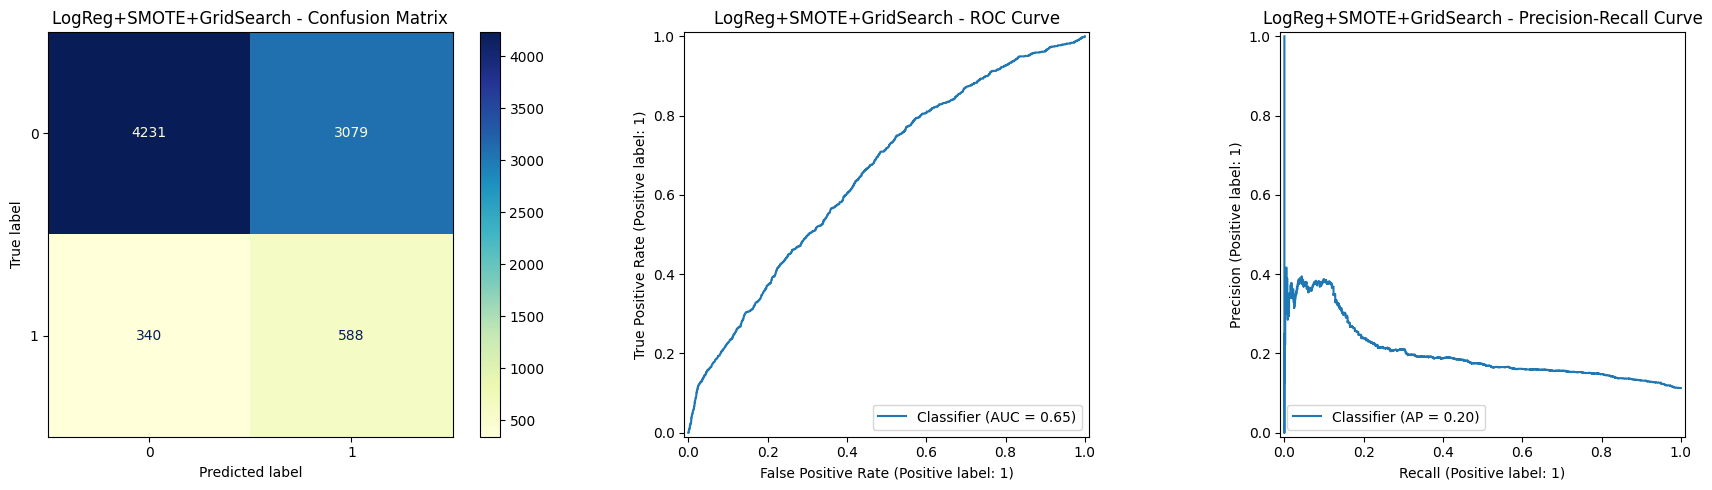

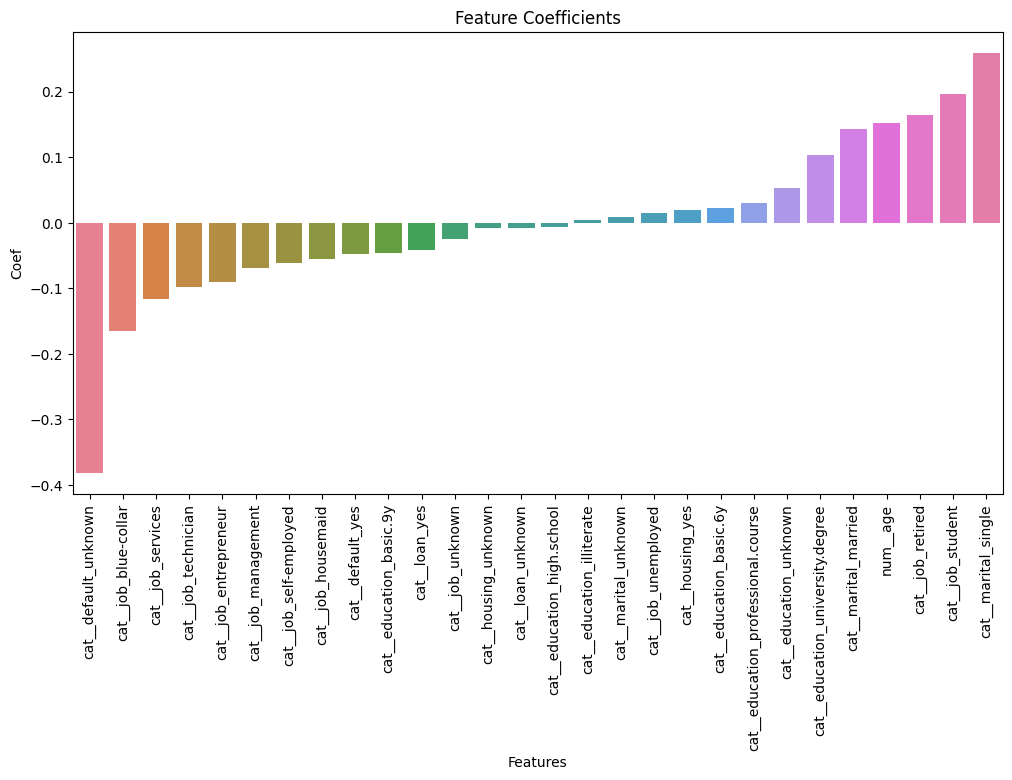

Best parameters: {'model__C': 10, 'model__class_weight': None, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


In [36]:

# Define the pipeline with SMOTE and Logistic Regression
smote_lr_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(random_state=42, max_iter=10000))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs', 'liblinear'],
    'model__class_weight': [None, 'balanced'],  
    'model__max_iter': [1000]
}

# GridSearchCV with cross-validation
grid_search = GridSearchCV(
    smote_lr_pipe,
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
gs_start_time = time.time()
grid_search.fit(X_train, y_train)
gs_fit_duration = time.time() - gs_start_time

# Best estimator and predictions
best_smote_lr = grid_search.best_estimator_
y_pred = best_smote_lr.predict(X_test)
y_proba = best_smote_lr.predict_proba(X_test)[:, 1]

# Record and print metrics
record_metrics('LogReg+SMOTE+GridSearch', best_smote_lr, X_train, y_test, y_pred, y_proba, gs_fit_duration)
print_metrics('LogReg+SMOTE+GridSearch', best_smote_lr, X_train, y_test, y_pred, y_proba, gs_fit_duration)
show_metric_plots('LogReg+SMOTE+GridSearch', y_test, y_pred, y_proba)
plot_feature_importance(best_smote_lr)

print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
DecisionTree+GridSearch Metrics:
Fit Duration: 4.2307 seconds
Test Accuracy: 0.6970
Train Accuracy: 0.6988
Accuracy: 0.6970
Recall: 0.4709
F1 Score: 0.2593
ROC AUC: 0.6370
Confusion Matrix:
[[5305 2005]
 [ 491  437]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      7310
           1       0.18      0.47      0.26       928

    accuracy                           0.70      8238
   macro avg       0.55      0.60      0.53      8238
weighted avg       0.83      0.70      0.75      8238



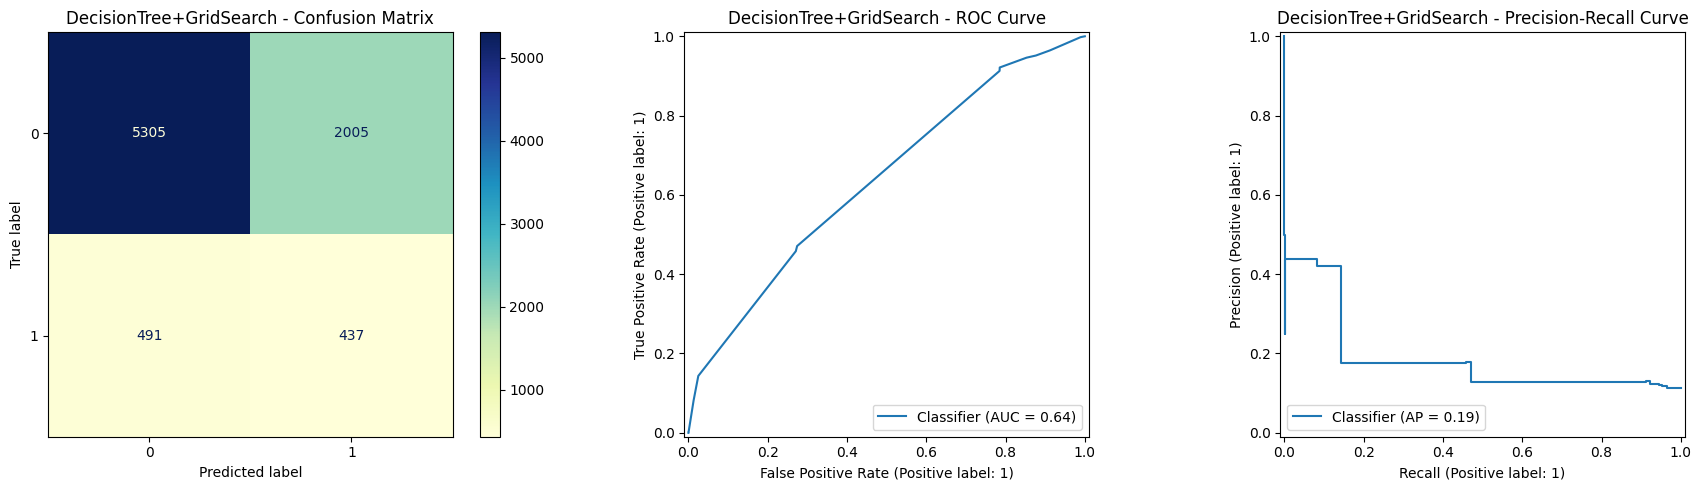

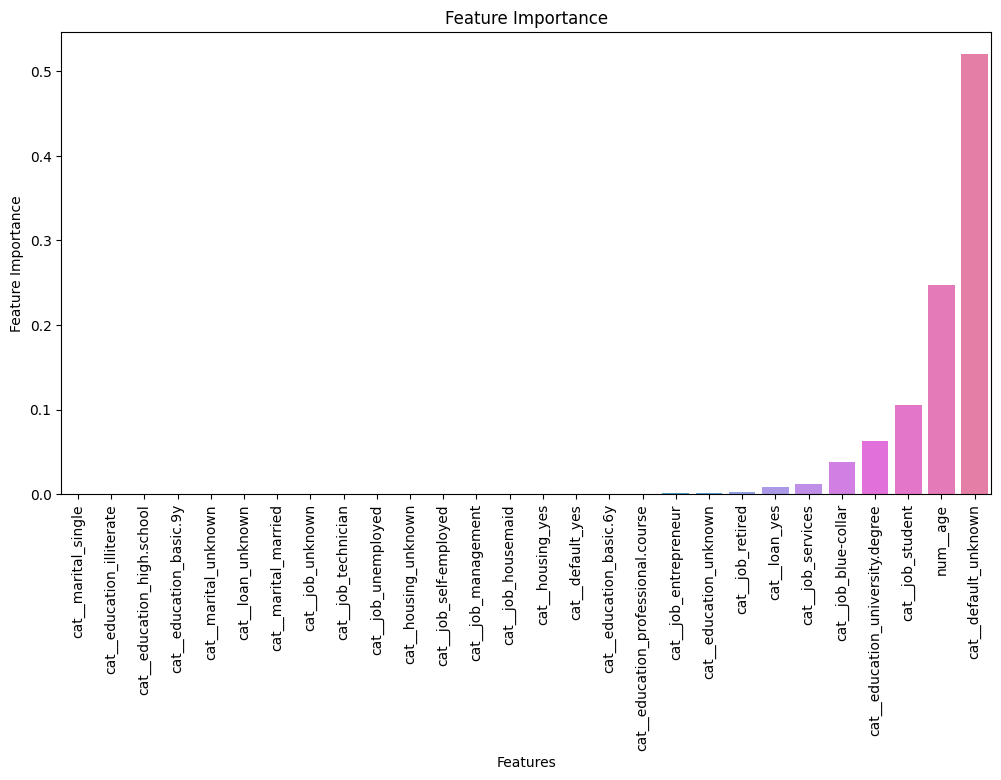

Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}


In [37]:

# Pipeline for Decision Tree with SMOTE and scaling
dt_grid_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler(with_mean=False)),
    ('model', DecisionTreeClassifier(random_state=42))
])

# Define parameter grid for Decision Tree
dt_param_grid = {
    'model__max_depth': [3, 5,10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__criterion': ['gini', 'entropy']
}

# Pipeline for Decision Tree with scaling
# dt_grid_pipe = Pipeline([
#     ('smote', SMOTE(random_state=42)),
#     ('scale', StandardScaler(with_mean=False)),
#     ('model', DecisionTreeClassifier(random_state=42))
# ])

# GridSearchCV for Decision Tree
dt_grid_search = GridSearchCV(
    dt_grid_pipe,
    dt_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
dt_gs_start_time = time.time()
dt_grid_search.fit(X_train, y_train)
dt_gs_fit_duration = time.time() - dt_gs_start_time

# Best estimator and predictions
best_dt = dt_grid_search.best_estimator_
y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]

# Record and print metrics
record_metrics('DecisionTree+GridSearch', best_dt, X_train, y_test, y_pred, y_proba, dt_gs_fit_duration)
print_metrics('DecisionTree+GridSearch', best_dt, X_train, y_test, y_pred, y_proba, dt_gs_fit_duration)
show_metric_plots('DecisionTree+GridSearch', y_test, y_pred, y_proba)
plot_feature_importance(best_dt)

print("Best parameters:", dt_grid_search.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
KNN+GridSearch Metrics:
Fit Duration: 85.5348 seconds
Test Accuracy: 0.7529
Train Accuracy: 0.7953
Accuracy: 0.7529
Recall: 0.3308
F1 Score: 0.2317
ROC AUC: 0.5980
Confusion Matrix:
[[5895 1415]
 [ 621  307]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      7310
           1       0.18      0.33      0.23       928

    accuracy                           0.75      8238
   macro avg       0.54      0.57      0.54      8238
weighted avg       0.82      0.75      0.78      8238



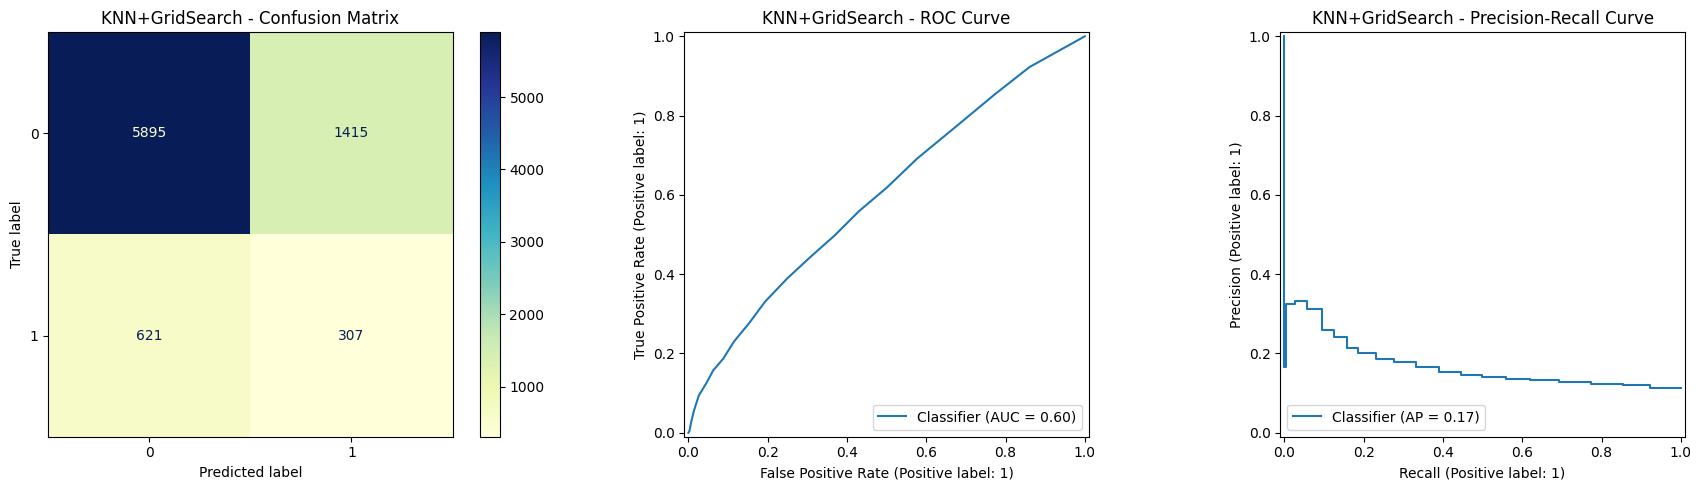

This model does not provide feature importances or coefficients.
Best parameters: {'model__metric': 'manhattan', 'model__n_neighbors': 19, 'model__weights': 'uniform'}


In [38]:


# Define parameter grid for KNN
knn_param_grid = {
    'model__n_neighbors': list(range(1, 21)),  # Testing from 1 to 20 neighbors
    'model__weights': ['uniform', 'distance'],
    'model__metric' : ['euclidean', 'manhattan', 'minkowski']
}

# Pipeline for KNN with scaling
# knn_grid_pipe = Pipeline([
#     ('smote', SMOTE(random_state=42)),
#     ('scale', StandardScaler(with_mean=False)),
#     ('model', KNeighborsClassifier())
# ])

knn_grid_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler(with_mean=False)),
    ('model', KNeighborsClassifier())
])
# GridSearchCV for KNN
knn_grid_search = GridSearchCV(
    knn_grid_pipe,
    knn_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
knn_gs_start_time = time.time()
knn_grid_search.fit(X_train, y_train)
knn_gs_fit_duration = time.time() - knn_gs_start_time

# Best estimator and predictions
best_knn = knn_grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:, 1]

# Record and print metrics
record_metrics('KNN+GridSearch', best_knn, X_train, y_test, y_pred, y_proba, knn_gs_fit_duration)
print_metrics('KNN+GridSearch', best_knn, X_train, y_test, y_pred, y_proba, knn_gs_fit_duration)
show_metric_plots('KNN+GridSearch', y_test, y_pred, y_proba)
plot_feature_importance(best_knn)

# KNN does not provide feature importances, but you can print the best parameters
print("Best parameters:", knn_grid_search.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x103a68400>
Traceback (most recent call last):
  File "/Users/sudharsana.soudhari/.pyenv/versions/3.12.10/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/sudharsana.soudhari/.pyenv/versions/3.12.10/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/sudharsana.soudhari/.pyenv/versions/3.12.10/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110068400>
Traceback (most recent call last):
  File "/Users/sudharsana.soudhari/.pyenv/versions/3.12.10/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/sudharsana.soudhari/.pyenv/versions/3.12.10/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/sudharsana.soudhari/.pyenv/versions/3.12.10/lib/python3.12/m

SVM+SMOTE+GridSearch Metrics:
Fit Duration: 7247.3393 seconds
Test Accuracy: 0.4993
Train Accuracy: 0.5097
Accuracy: 0.4993
Recall: 0.7166
F1 Score: 0.2438
ROC AUC: 0.6441
Confusion Matrix:
[[3448 3862]
 [ 263  665]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.47      0.63      7310
           1       0.15      0.72      0.24       928

    accuracy                           0.50      8238
   macro avg       0.54      0.59      0.43      8238
weighted avg       0.84      0.50      0.58      8238



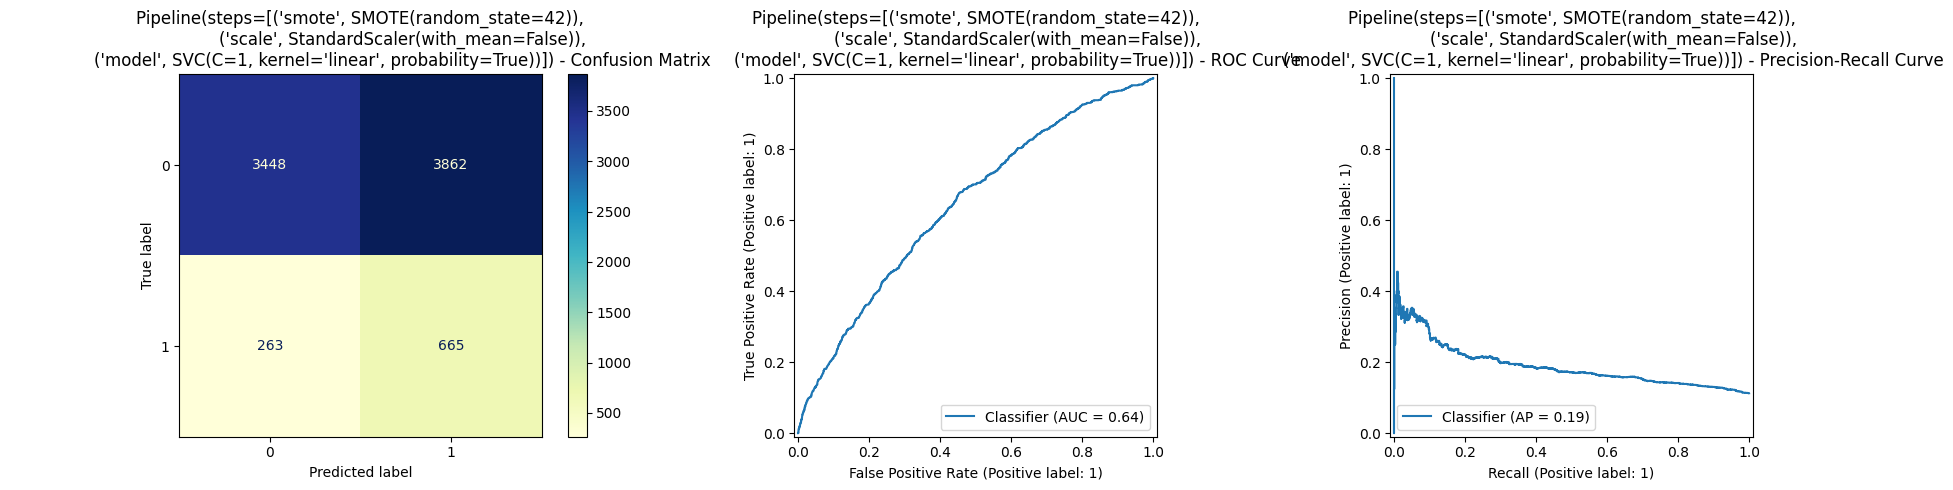

Best parameters: {'model__C': 1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'linear'}


In [46]:

# Use ImbPipeline to ensure SMOTE is applied only to training data during cross-validation
svm_grid_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler(with_mean=False)),
    ('model', SVC(class_weight='balanced', probability=True))
])

# Define parameter grid for SVM
svm_param_grid = {
    'model__C': [1, 5],
    'model__kernel': ['linear'], # Testing different kernels
    'model__gamma': ['scale'], # Degree for polynomial kernel
    'model__class_weight': [None, 'balanced']  #  Class weights to handle class imbalance
}



# Reduce cv folds and n_jobs for faster execution
svm_grid_search = GridSearchCV(
    svm_grid_pipe,
    svm_param_grid,
    scoring='f1',
    cv=2,           # Reduce from 5 to 3 folds
    n_jobs=3,       # 2 parallel jobs (can be adjusted as needed)
    verbose=1
)

# Fit the model
svm_gs_start_time = time.time()
svm_grid_search.fit(X_train, y_train)
svm_gs_fit_duration = time.time() - svm_gs_start_time

# Best estimator and predictions
best_svm = svm_grid_search.best_estimator_
y_pred = best_svm.predict(X_test)
y_proba = best_svm.predict_proba(X_test)[:, 1]

# Record and print metrics
record_metrics('SVM+SMOTE+GridSearch', best_svm, X_train, y_test, y_pred, y_proba, svm_gs_fit_duration)
print_metrics('SVM+SMOTE+GridSearch', best_svm, X_train, y_test, y_pred, y_proba, svm_gs_fit_duration)
show_metric_plots(best_svm, y_test, y_pred, y_proba)

print("Best parameters:", svm_grid_search.best_params_)

In [47]:
metric_df = pd.DataFrame({
    'Model': Models,
    'Accuracy': accuracy_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'ROC AUC': roc_auc_scores,
    'Fit Duration (s)': fit_durations,
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
})
metric_df = metric_df.sort_values(by='F1 Score', ascending=False)
pd.set_option('display.max_colwidth', None)
metric_df

,Model,Accuracy,Recall,F1 Score,ROC AUC,Fit Duration (s),Train Accuracy,Test Accuracy
1,DecisionTree+GridSearch,0.697014,0.470905,0.259347,0.636983,4.230701,0.698756,0.697014
0,LogReg+SMOTE+GridSearch,0.584972,0.633621,0.255930,0.652689,10.727638,0.592534,0.584972
3,SVM+SMOTE+GridSearch,0.499272,0.716595,0.243813,0.644063,7247.339279,0.509712,0.499272
2,KNN+GridSearch,0.752853,0.330819,0.231698,0.597951,85.534759,0.795296,0.752853



**Key Observations:**
- **Recall vs. Accuracy:** Models with higher recall (Logistic Regression, SVM) have lower accuracy, indicating better identification of the minority class (deposit = 'yes') at the expense of more false positives.
- **KNN and Decision Tree:** These models achieve higher accuracy but lower recall, suggesting they are biased toward the majority class.
- **F1 Score and ROC AUC:** All models have relatively low F1 scores, reflecting the challenge of class imbalance. ROC AUC values are moderate, indicating some ability to distinguish between classes.
- **Computation Time:** SVM is computationally expensive compared to other models, making it less practical for large datasets.
- **SMOTE Impact:** Using SMOTE improved recall and F1 scores for minority class detection, but did not dramatically improve overall accuracy.

**Overall Conclusion:**
- No single model dominates across all metrics. The choice depends on business priorities: if identifying deposit subscribers is critical, prioritize recall and F1 score.
- Further improvements could be achieved with more feature engineering, alternative resampling strategies, or ensemble methods.
- Real-world deployment should consider model interpretability, fairness, and operational constraints in addition to raw performance metrics.

##### Questions

The analysis of the marketing campaign data, particularly focusing on model metrics, revealed a key challenge: the imbalanced dataset, heavily skewed toward unsuccessful outcomes, significantly limited our ability to identify features that drive strong model performance. This observation leads to several important questions about the campaign's execution and potential strategies for improvement:

Campaign Execution & Data Imbalance: Was the marketing campaign's strategy or targeting inherently flawed, leading to such a disproportionate number of unsuccessful outcomes? A more balanced dataset, reflecting a higher success rate, would allow for more effective feature learning and model optimization.

Customer Reach-out Methods: We noticed a particularly high success rate for customers contacted via cellular phones. This raises the question of whether the bank actively explored or adopted other mobile-centric customer outreach methods, such as text messages or WhatsApp messages, which might align with customer preferences and communication habits, potentially improving engagement and success rates.

Contact Duration & Resource Allocation: Campaigns with a longer contact duration showed a higher success rate. Did the bank allocate sufficient resources, in terms of staff training, tools, or time per customer interaction, to maximize the chances of a successful outcome, especially for those longer engagements? Understanding and optimizing this aspect could directly impact campaign effectiveness.
